In [135]:
# ==========================================
# 0. IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score, auc)
from imblearn.over_sampling import SMOTE
import pickle
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("="*70)
print("PREDIKSI OBESITAS SISWA SMA/SMK - MACHINE LEARNING")
print("="*70)
print("Semua libraries berhasil dimuat!")

PREDIKSI OBESITAS SISWA SMA/SMK - MACHINE LEARNING
Semua libraries berhasil dimuat!


In [136]:
# ==========================================
# 1. DATA COLLECTION (PENGUMPULAN DATA)
# ==========================================
print("\n" + "="*70)
print("TAHAP 1: DATA COLLECTION (PENGUMPULAN DATA)")
print("="*70)

# Load dataset
df = pd.read_csv("data_siswa.csv", encoding='latin1')
print(f"Data berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

# Tampilkan semua kolom
print("\nDaftar Kolom:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

# Drop kolom yang completely empty
df = df.dropna(axis=1, how="all")
print(f"\nKolom kosong dihapus: Sisa {df.shape[1]} kolom")

# Info dataset
print(f"\nInformasi Dataset:")
print(f"  Jumlah baris: {df.shape[0]}")
print(f"  Jumlah kolom: {df.shape[1]}")
print(f"  Missing values total: {df.isnull().sum().sum()}")
print(f"  Duplikat: {df.duplicated().sum()}")



TAHAP 1: DATA COLLECTION (PENGUMPULAN DATA)
Data berhasil dimuat: 2505 baris, 27 kolom

Daftar Kolom:
  1. Timestamp
  2. Nama lengkap
  3. Jenis Kelamin
  4. Usia
  5. Jalur Pendidikan
  6. Asal Sekolah
  7. Kelas
  8. Berapa berat badan kamu sekarang? (dalam kilogram)
  9. Berapa tinggi badan kamu sekarang? (dalam centimeter)
  10. Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari?
  11. Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?
  12. Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji
  13. Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?
  14. Secara umum, jenis makanan apa yang paling sering kamu konsumsi?
  15. Berapa kali kamu berolahraga dalam seminggu?
  16. Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?
  17. Seberapa sering kamu dalam melakukan aktivitas fisik sehar

In [137]:
# mengecek di kolom mana dan handle missing dengan median/mode

# Hitung jumlah NaN per kolom
nan_kolom_perhitungan = df.isnull().sum()

# Filter hanya kolom yang memiliki NaN (> 0) dan simpan namanya dalam list
kolom_dengan_nan = nan_kolom_perhitungan[nan_kolom_perhitungan > 0].index.tolist()

print("-" * 50)
for col in kolom_dengan_nan:
    # Cek tipe data: Jika numerik (angka), gunakan Median
    if pd.api.types.is_numeric_dtype(df[col]):
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Kolom Numerik '{col}' diisi dengan MEDIAN: {median_value:.2f}")
    
    # Cek tipe data: Jika kategorikal/teks, gunakan Mode
    elif pd.api.types.is_object_dtype(df[col]):
        try:
            mode_value = df[col].mode()[0]
        except IndexError:
            mode_value = "NULL_FILLED" 
        df[col].fillna(mode_value, inplace=True)
        print(f"Kolom Kategorikal '{col}' \ndiisi dengan MODE: {mode_value}")
    else:
        # Jika ada tipe data lain (misalnya boolean)
        print(f"Kolom '{col}' tidak diimputasi karena tipe data tidak dikenal.")

--------------------------------------------------
Kolom Kategorikal 'Apakah di lingkungan rumah/sekolah kamu ada fasilitas olahraga (lapangan, gym, tempat lari, dll)?' 
diisi dengan MODE: Ya, mudah diakses


In [138]:
# ==========================================
# 2. DATA CLEANING & PREPROCESSING
# ==========================================
print("\n" + "="*70)
print("TAHAP 2: DATA CLEANING & PREPROCESSING")
print("="*70)

# 2.1 Fungsi untuk membersihkan angka dengan satuan
def clean_numeric(val):
    """Membersihkan nilai numerik dengan satuan (kg, cm, tahun)"""
    if pd.isna(val):
        return np.nan
    val = str(val).lower()
    for unit in ["kg", "cm", "tahun", "th", "jam", "kilogram", "centimeter"]:
        val = val.replace(unit, "")
    val = val.replace(",", ".").strip()
    try:
        return float(val)
    except:
        return np.nan

print("Fungsi pembersih numerik dibuat")


TAHAP 2: DATA CLEANING & PREPROCESSING
Fungsi pembersih numerik dibuat


In [139]:
# 2.2 Mapping kategori → nilai numerik (STANDARDIZED)
mapping_tidur = {
    "< 5 jam": 4,
    "5-6 jam": 5.5,
    "5–6 jam": 5.5,
    "5 - 6 jam": 5.5,
    "7-8 jam": 7.5,
    "7 -8 jam": 7.5,
    "7 - 8 jam": 7.5,
    "> 8 jam": 9
}

mapping_makan = {
    "1 kali": 1,
    "2 kali": 2,
    "3 kali": 3,
    "> 3 kali": 4
}

mapping_jajan = {
    "0 - 2 kali": 1,
    "0-2 kali": 1,
    "3 - 5 kali": 4,
    "3-5 kali": 4,
    "4 - 5 kali": 4.5,
    "6 - 10 kali": 8,
    "6-10 kali": 8,
    "> 10 kali": 12,
    "> 10  kali": 12,
    ">10 kali": 12
}

mapping_fastfood = {
    "0 - 2 kali": 1,
    "0-2 kali": 1,
    "3 - 5 kali": 4,
    "3-5 kali": 4,
    "3 -  5 kali": 4,
    "> 5 kali": 7,
    ">5 kali": 7
}

mapping_minuman = {
    "0 - 2 gelas": 1,
    "0-2 gelas": 1,
    "3 - 5 gelas": 4,
    "3-5 gelas": 4,
    "6 - 10 gelas": 8,
    "6-10 gelas": 8,
    "10 - 6 gelas": 8,
    "10 gelas": 10,
    "> 10 gelas": 12,
    ">10 gelas": 12,
    ">10gelas": 12
}

mapping_makan_malam = {
    "0 Kali": 0,
    "0 kali": 0,
    "1 Kali": 1,
    "1 kali": 1,
    "2 - 3 kali": 2.5,
    "2 - 3 Kali": 2.5,
    "2-3 kali": 2.5,
    "2 -  3 Kali": 2.5,
    "4 kali": 4,
    "5 Kali": 5,
    "> 4 kali": 6,
    "> 4 Kali": 6,
    ">4 kali": 6,
    "4 kali atau lebih": 6
}

mapping_frekuensi_olahraga = {
    "Tidak pernah": 0,
    "1 - 2 kali": 1.5,
    "1-2 kali": 1.5,
    "3 - 4 kali": 3.5,
    "3-4 kali": 3.5,
    "5 - 7 kali": 6,
    "5-7 kali": 6,
    "> 7 kali": 8
}

mapping_durasi_olahraga = {
    "< 15 menit": 10,
    "<15 menit": 10,
    "15 - 30 menit": 22.5,
    "15-30 menit": 22.5,
    "31 -60 menit": 45,
    "31 - 60 menit": 45,
    "30-60 menit": 45,
    "> 60 menit": 75,
    ">60 menit": 75
}

mapping_video_makanan={
    "tidak pernah":0,
    "Tidak pernah":0,
    "< 1 jam per minggu":0.5,
    "1-3 jam per minggu":2,
    "1 - 3 jam per minggu":2,
    "4-6 jam per minggu":5,
    "4 - 6 jam per minggu":5,
    "7-10 jam per minggu":8.5,
    "7 - 10 jam per minggu":8.5,
    "10 jam per minggu":10  
}

print("Mapping kategori dibuat")



Mapping kategori dibuat


In [140]:
# 2.3 Bersihkan kolom numerik dasar
col_berat = "Berapa berat badan kamu sekarang? (dalam kilogram)"
col_tinggi = "Berapa tinggi badan kamu sekarang? (dalam centimeter)"

df["berat_kg"] = df[col_berat].apply(clean_numeric)
df["tinggi_cm"] = df[col_tinggi].apply(clean_numeric)
df["usia_tahun"] = df["Usia"].apply(clean_numeric)

print(f"Kolom numerik dibersihkan:")
print(f"  - berat_kg: {df['berat_kg'].notna().sum()} valid values")
print(f"  - tinggi_cm: {df['tinggi_cm'].notna().sum()} valid values")
print(f"  - usia_tahun: {df['usia_tahun'].notna().sum()} valid values")


Kolom numerik dibersihkan:
  - berat_kg: 2464 valid values
  - tinggi_cm: 2458 valid values
  - usia_tahun: 2457 valid values


In [141]:
# 2.4 Terapkan mapping ke kolom-kolom kategorikal
col_makan_utama = "Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari?"
col_jajan = "Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?"
col_fastfood = "Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji"
col_minuman = "Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?"
col_tidur = "Rata-rata, berapa jam kamu tidur setiap malam?"
col_olahraga = "Berapa kali kamu berolahraga dalam seminggu?"
col_durasi_olahraga = "Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?"
col_aktivitas_old = "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik turun tangga, kegiatan di rumah/sekolah)?"
col_aktivitas_new = "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik & turun tangga, kegiatan di rumah/sekolah)?"
col_stres = "Seberapa sering kamu merasa stres (karena tugas, sekolah, keluarga, dsb)?"
col_teman = "Seberapa besar pengaruh teman terhadap kebiasaan kamu jajan/makan (misalnya diajak nongkrong, makan bersama)?"
col_keluarga = "Apakah ada keluarga Anda yang pernah atau sedang mengalami obesitas?"
col_makan_stres = "Dalam 7 hari terakhir, seberapa sering Anda mengonsumsi makanan akibat perasaan stres?"
col_makan_malam = "Dalam 7 hari terakhir, berapa kali Anda mengonsumsi makanan utama atau cemilan setelah pukul 21.00?"
col_video_makanan = "Dalam semiggu seberapa sering kamu menonton video makanan di HP/Komputer"

# Apply mappings
df["makan_per_hari"] = df[col_makan_utama].map(mapping_makan)
df["jajan_per_minggu"] = df[col_jajan].map(mapping_jajan)
df["fastfood_per_minggu"] = df[col_fastfood].map(mapping_fastfood)
df["minuman_manis_per_minggu"] = df[col_minuman].map(mapping_minuman)
df["durasi_tidur_jam"] = df[col_tidur].map(mapping_tidur)
df["makan_setelah_21"] = df[col_makan_malam].map(mapping_makan_malam)
df["durasi_olahraga"] = df[col_durasi_olahraga].map(mapping_durasi_olahraga)
df["video_makanan"] = df[col_video_makanan].map(mapping_video_makanan)

print(f"Mapping kategorikal diterapkan")


Mapping kategorikal diterapkan


In [142]:
# 2.5 Kolom aktivitas fisik (numerik langsung dari survey 1-5)
if col_aktivitas_old in df.columns:
    df["aktivitas_fisik"] = pd.to_numeric(df[col_aktivitas_old], errors='coerce')

if col_aktivitas_new in df.columns:
    df["aktivitas_fisik_harian_new"] = pd.to_numeric(df[col_aktivitas_new], errors='coerce')


In [143]:
# 2.6 Kolom stres, pengaruh teman, makan karena stres (numerik langsung 1-5)
if col_stres in df.columns:
    df["tingkat_stres"] = pd.to_numeric(df[col_stres], errors='coerce')

if col_teman in df.columns:
    df["pengaruh_teman"] = pd.to_numeric(df[col_teman], errors='coerce')

if col_makan_stres in df.columns:
    df["makan_karena_stres"] = pd.to_numeric(df[col_makan_stres], errors='coerce')

print(f"Kolom aktivitas fisik dan stres diproses")

Kolom aktivitas fisik dan stres diproses


In [144]:
# 2.7 Filter data valid
df = df[df["berat_kg"].notna() & df["tinggi_cm"].notna()]
df = df[(df["berat_kg"] > 20) & (df["berat_kg"] < 200)]
df = df[(df["tinggi_cm"] > 100) & (df["tinggi_cm"] < 220)]

print(f"Data difilter: {len(df)} baris valid")


Data difilter: 2410 baris valid


In [145]:
# 2.8 Hitung BMI
df["BMI"] = df["berat_kg"] / ((df["tinggi_cm"] / 100) ** 2)

# Filter BMI yang masuk akal (10 - 60)
df = df[(df["BMI"] >= 10) & (df["BMI"] <= 60)]

print(f"[2.8] BMI dihitung:")
print(f"  BMI Min : {df['BMI'].min():.2f}")
print(f"  BMI Max : {df['BMI'].max():.2f}")
print(f"  BMI Mean: {df['BMI'].mean():.2f}")
print(f"  Jumlah data setelah filter: {len(df)}")


[2.8] BMI dihitung:
  BMI Min : 12.49
  BMI Max : 59.17
  BMI Mean: 21.40
  Jumlah data setelah filter: 2405


In [146]:
# ==========================================
# 3. FEATURE ENGINEERING & ENCODING
# ==========================================
print("\n" + "="*70)
print("TAHAP 3: FEATURE ENGINEERING & ENCODING")
print("="*70)

# 3.1 Kategorisasi BMI - STANDAR ASIA
print("Kategorisasi BMI - Standar Asia:")
print("    - < 18.5       : Kurus (Underweight)")
print("    - 18.5 - 22.9  : Normal (Ideal)")
print("    - 23.0 - 24.9  : Overweight")
print("    - 25.0 - 29.9  : Obesitas Kelas I")
print("    - 30.0 - 39.9  : Obesitas Kelas II")
print("    - >= 40        : Obesitas Morbid (Kelas III)")

def bmi_category_asia(bmi):
    """Kategorisasi BMI berdasarkan standar Asia"""
    if bmi < 18.5:
        return "Kurus"
    elif 18.5 <= bmi < 23:
        return "Normal"
    elif 23 <= bmi < 25:
        return "Overweight"
    elif 25 <= bmi < 30:
        return "Obesitas I"
    elif 30 <= bmi < 40:
        return "Obesitas II"
    else:
        return "Obesitas Morbid"

df["kategori_BMI"] = df["BMI"].apply(bmi_category_asia)



TAHAP 3: FEATURE ENGINEERING & ENCODING
Kategorisasi BMI - Standar Asia:
    - < 18.5       : Kurus (Underweight)
    - 18.5 - 22.9  : Normal (Ideal)
    - 23.0 - 24.9  : Overweight
    - 25.0 - 29.9  : Obesitas Kelas I
    - 30.0 - 39.9  : Obesitas Kelas II
    - >= 40        : Obesitas Morbid (Kelas III)


In [147]:
# 3.2 Label untuk ML - Obesitas jika BMI >= 25 (standar Asia)
df["label_obesitas"] = df["BMI"].apply(lambda x: 1 if x >= 25 else 0)

print("\nDistribusi Kategori BMI:")
print(df["kategori_BMI"].value_counts())

print("\nLabel Obesitas (BMI >= 25):")
print(f"  0 (Tidak Obesitas): {(df['label_obesitas']==0).sum()} ({(df['label_obesitas']==0).mean()*100:.1f}%)")
print(f"  1 (Obesitas)      : {(df['label_obesitas']==1).sum()} ({(df['label_obesitas']==1).mean()*100:.1f}%)")



Distribusi Kategori BMI:
kategori_BMI
Normal             1364
Kurus               444
Overweight          291
Obesitas I          236
Obesitas II          66
Obesitas Morbid       4
Name: count, dtype: int64

Label Obesitas (BMI >= 25):
  0 (Tidak Obesitas): 2099 (87.3%)
  1 (Obesitas)      : 306 (12.7%)


In [148]:
print("\nEncoding Variabel Kategorikal:")

# Encoding jenis kelamin (Laki-laki = 1, Perempuan = 0)
df["jenis_kelamin"] = df["Jenis Kelamin"].apply(
    lambda x: 1 if str(x).strip().lower() == "laki-laki" else 0
)
print(f"  Jenis Kelamin: Laki-laki=1, Perempuan=0")

# Encoding riwayat keluarga obesitas (Iya = 1, Tidak = 0, Ada = 1, Tidak ada = 0)
if col_keluarga in df.columns:
    df["keluarga_obesitas"] = df[col_keluarga].apply(
        lambda x: 1 if str(x).strip().lower() in ["iya", "ada"] else 0
    )
    print(f"  Keluarga Obesitas: Iya=1, Tidak=0, Ada=1, Tidak ada=0")


Encoding Variabel Kategorikal:
  Jenis Kelamin: Laki-laki=1, Perempuan=0
  Keluarga Obesitas: Iya=1, Tidak=0, Ada=1, Tidak ada=0


In [149]:
# 3.5 Simpan dataset bersih
df.to_csv("dataset_bersih_final.csv", index=False)
print("\nDataset bersih disimpan ke: dataset_bersih_final.csv")



Dataset bersih disimpan ke: dataset_bersih_final.csv



TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)

STATISTIK DESKRIPTIF:
        usia_tahun     berat_kg    tinggi_cm          BMI  makan_per_hari  \
count  2363.000000  2405.000000  2405.000000  2405.000000     2404.000000   
mean     16.217097    53.985879   158.865356    21.396563        2.779118   
std       0.973751    10.258338     8.111646     3.754168        0.610530   
min      14.000000    30.000000   115.000000    12.488522        1.000000   
25%      15.000000    48.000000   153.800000    19.100092        3.000000   
50%      16.000000    52.000000   159.000000    20.811655        3.000000   
75%      17.000000    58.000000   165.000000    22.939751        3.000000   
max      19.000000   167.000000   182.000000    59.171598        4.000000   

       jajan_per_minggu  minuman_manis_per_minggu  durasi_tidur_jam  \
count       2405.000000               2405.000000       2405.000000   
mean           3.958004                  2.772557          6.746154   
std            2.908066     

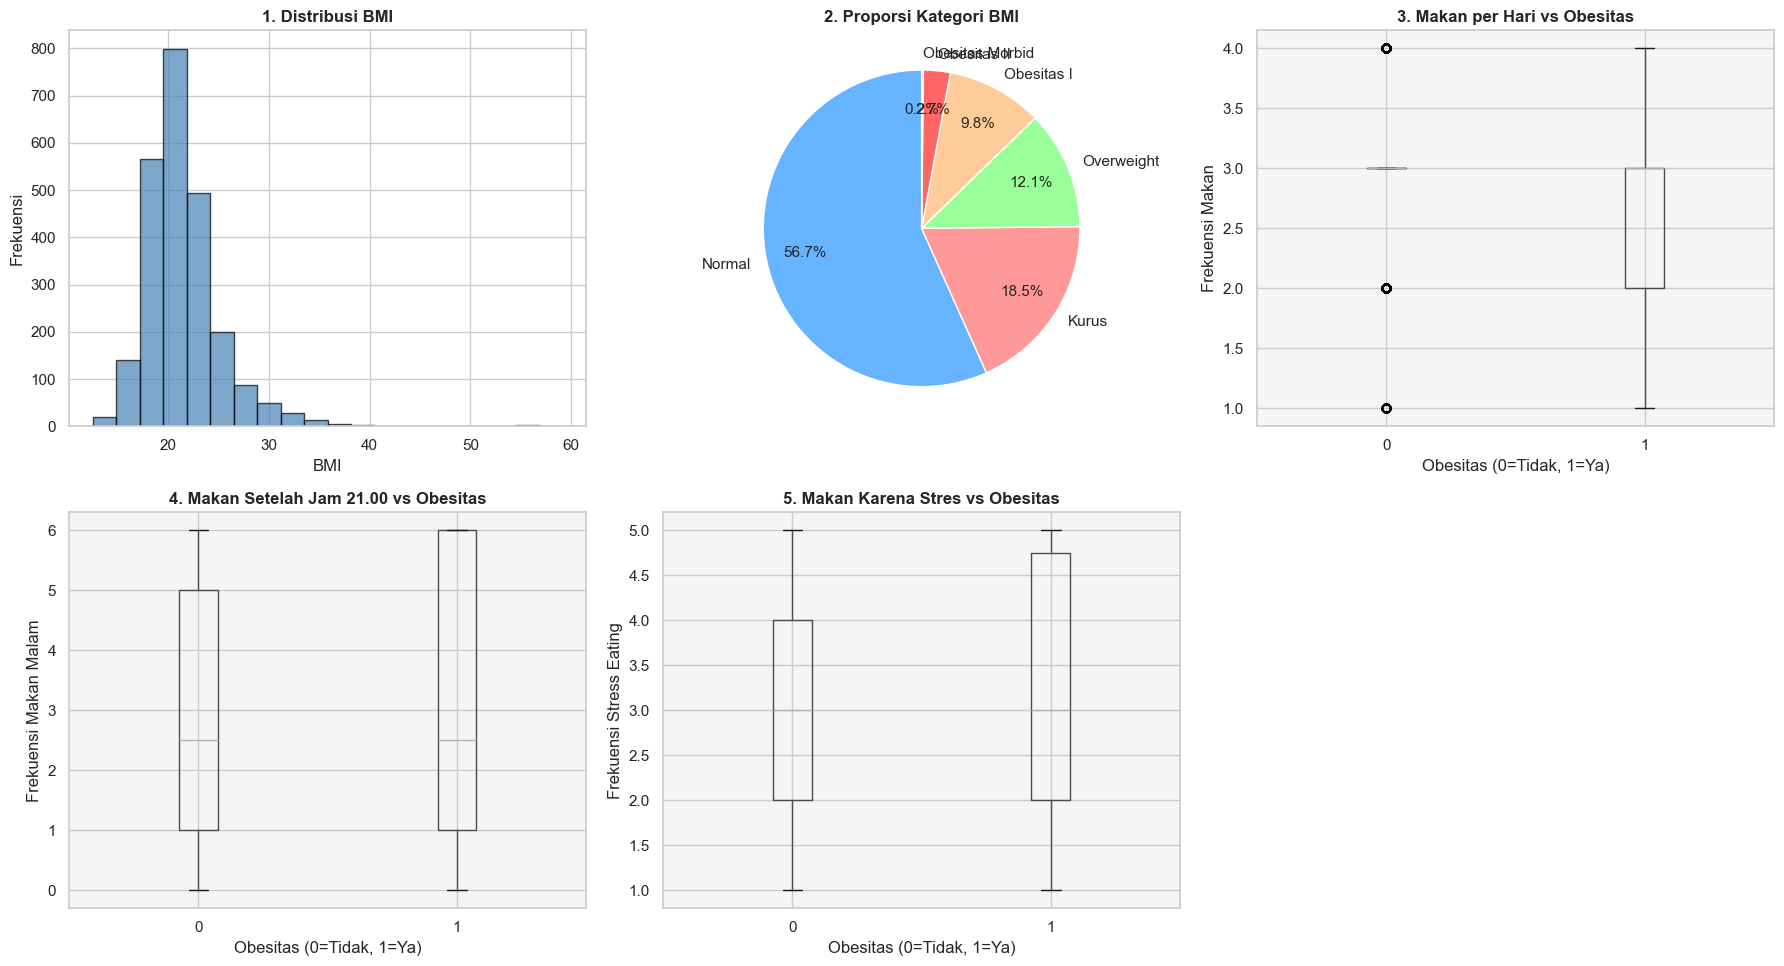


Visualisasi EDA disimpan: eda_overview_rapi.png


In [152]:
# ==========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
print("\n" + "="*70)
print("TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

# Kolom untuk Statistik Deskriptif (Tetap)
print("\nSTATISTIK DESKRIPTIF:")
desc_cols = ['usia_tahun', 'berat_kg', 'tinggi_cm', 'BMI', 'makan_per_hari',
             'jajan_per_minggu', 'minuman_manis_per_minggu', 'durasi_tidur_jam',
             'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres']
available_desc_cols = [c for c in desc_cols if c in df.columns]
print(df[available_desc_cols].describe())

# Visualisasi EDA: Ubah subplot menjadi 2 baris x 3 kolom (Total 6 slot)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Exploratory Data Analysis - Distribusi Utama & Korelasi Obesitas", fontsize=18, fontweight='bold', y=1.02) # Pindah suptitle

# Flatten the axes array for easier indexing: axes.flatten()
axes = axes.flatten()
plot_index = 0

# --- 1. Distribusi BMI (HISTOGRAM) ---
axes[plot_index].hist(df["BMI"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[plot_index].set_title("1. Distribusi BMI", fontweight='bold')
axes[plot_index].set_xlabel("BMI")
axes[plot_index].set_ylabel("Frekuensi")
plot_index += 1

# --- 2. Proporsi Kategori BMI (PIE CHART) ---
bmi_percentage_distribution = df['kategori_BMI'].value_counts(normalize=True) * 100
print("\nDistribusi Persentase Kategori BMI:")
print(bmi_percentage_distribution.apply(lambda x: f"{x:.2f}%"))

bmi_counts = df["kategori_BMI"].value_counts()
colors_pie = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#ff6666', '#cc99ff'] # Warna diatur ulang
axes[plot_index].pie(bmi_counts, labels=bmi_counts.index, autopct='%1.1f%%', startangle=90,
                     colors=colors_pie[:len(bmi_counts)], pctdistance=0.75, textprops={'fontsize': 11})
axes[plot_index].set_title("2. Proporsi Kategori BMI", fontweight='bold')
plot_index += 1

# --- 3. Makan per Hari vs Obesitas (BOXPLOT 1) ---
if 'makan_per_hari' in df.columns and 'label_obesitas' in df.columns:
    df.boxplot(column='makan_per_hari', by='label_obesitas', ax=axes[plot_index])
    axes[plot_index].set_title("3. Makan per Hari vs Obesitas", fontweight='bold')
    axes[plot_index].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[plot_index].set_ylabel("Frekuensi Makan")
    axes[plot_index].set_facecolor('whitesmoke')
    plt.suptitle('') # Hapus suptitle yang dibuat oleh boxplot by='...'
    plot_index += 1

# --- 4. Makan Setelah Jam 21.00 vs Obesitas (BOXPLOT 2) ---
if 'makan_setelah_21' in df.columns and 'label_obesitas' in df.columns:
    df.boxplot(column='makan_setelah_21', by='label_obesitas', ax=axes[plot_index])
    axes[plot_index].set_title("4. Makan Setelah Jam 21.00 vs Obesitas", fontweight='bold')
    axes[plot_index].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[plot_index].set_ylabel("Frekuensi Makan Malam")
    axes[plot_index].set_facecolor('whitesmoke')
    plt.suptitle('') # Hapus suptitle yang dibuat oleh boxplot by='...'
    plot_index += 1

# --- 5. Makan Karena Stres vs Obesitas (BOXPLOT 3) ---
if 'makan_karena_stres' in df.columns and 'label_obesitas' in df.columns:
    df.boxplot(column='makan_karena_stres', by='label_obesitas', ax=axes[plot_index])
    axes[plot_index].set_title("5. Makan Karena Stres vs Obesitas", fontweight='bold')
    axes[plot_index].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[plot_index].set_ylabel("Frekuensi Stress Eating")
    axes[plot_index].set_facecolor('whitesmoke')
    plt.suptitle('') # Hapus suptitle yang dibuat oleh boxplot by='...'
    plot_index += 1

# --- Menghapus Slot yang Tidak Terpakai ---
# Sisa slot yang tidak terpakai (hanya 1 jika 5 visualisasi di 6 slot)
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

# Tampilkan dan Simpan Plot
plt.tight_layout()
plt.savefig("eda_overview_rapi.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi EDA disimpan: eda_overview_rapi.png")

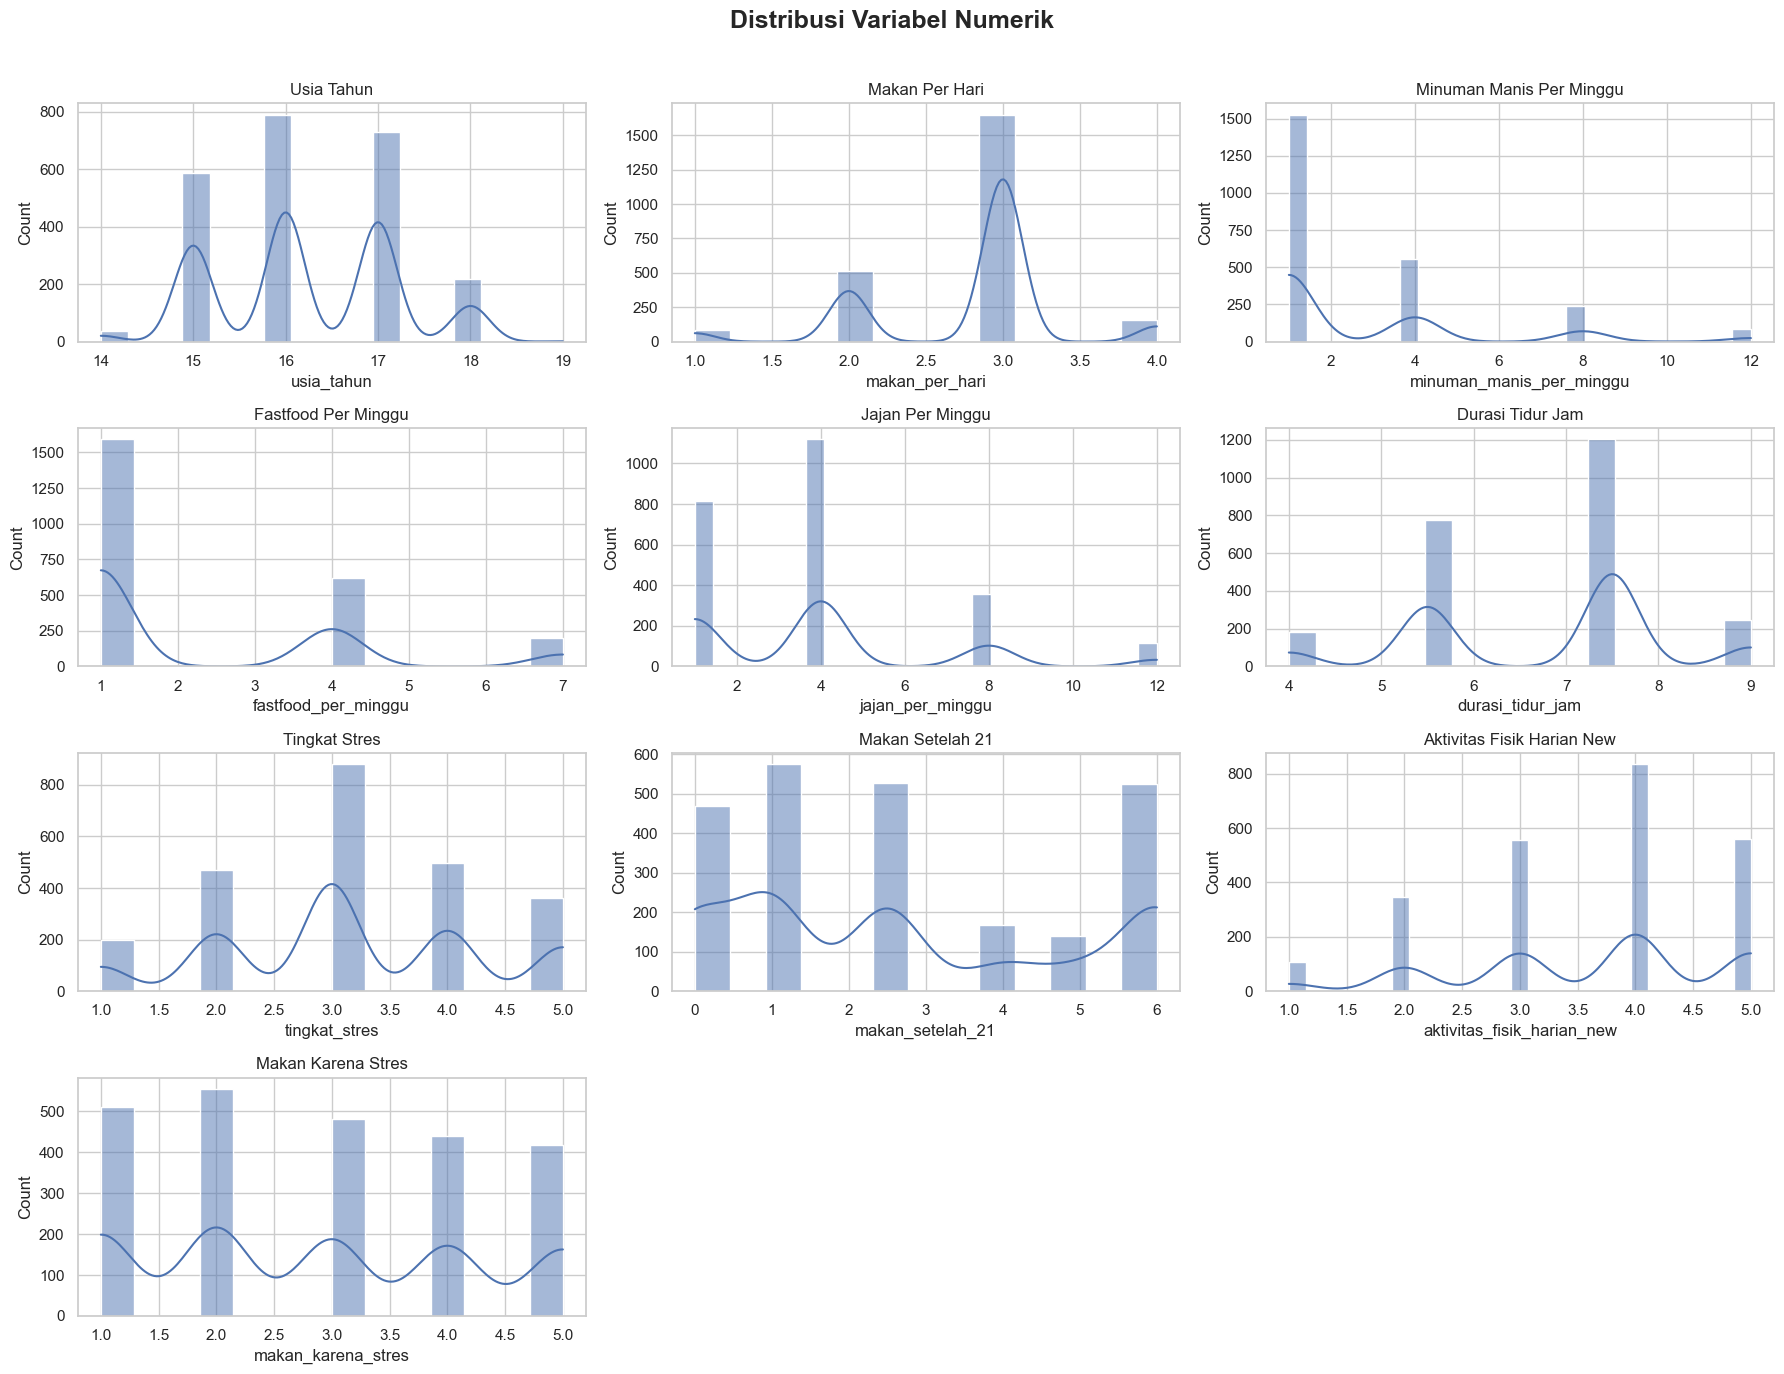

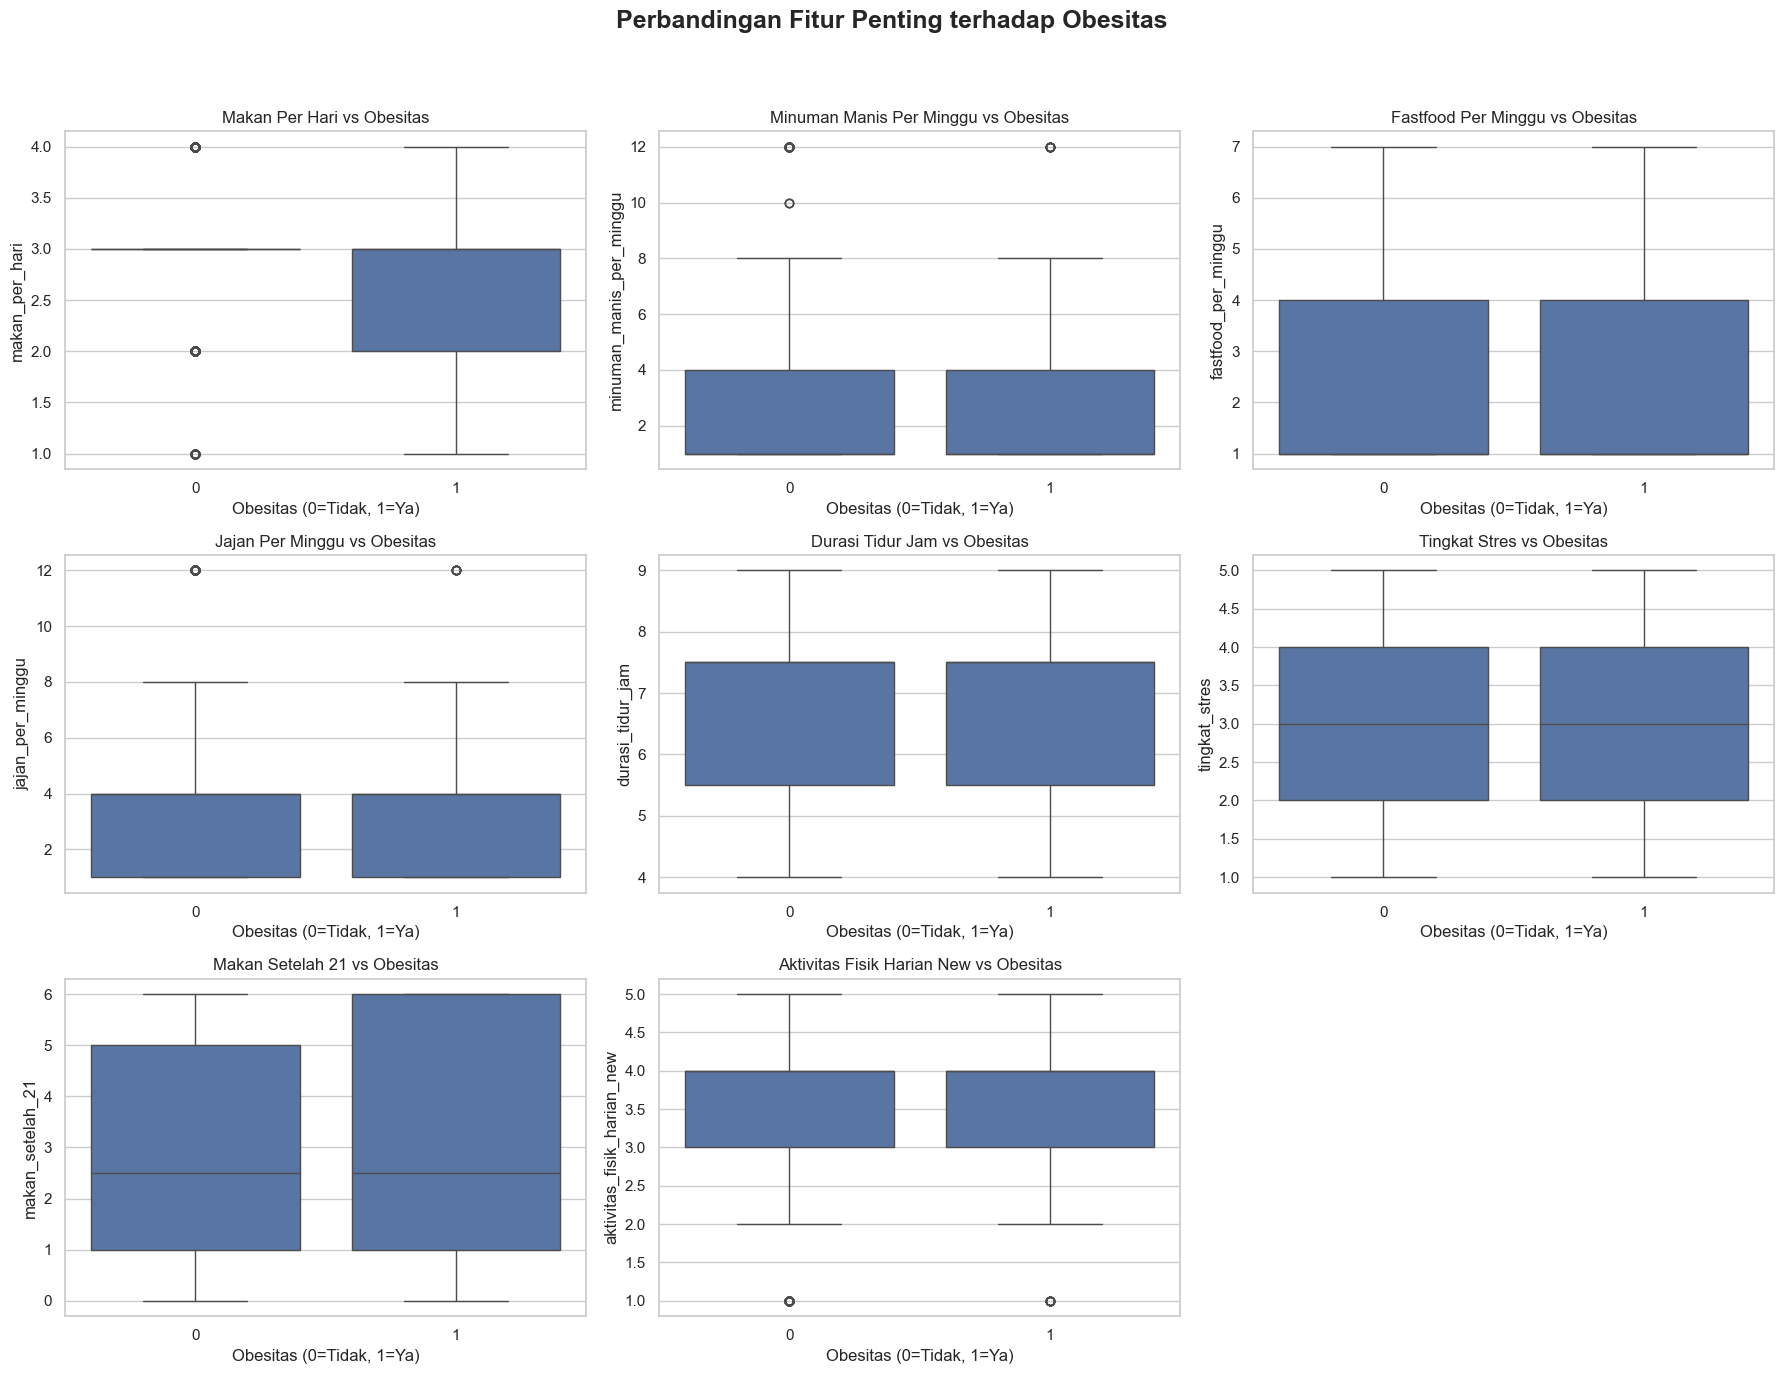

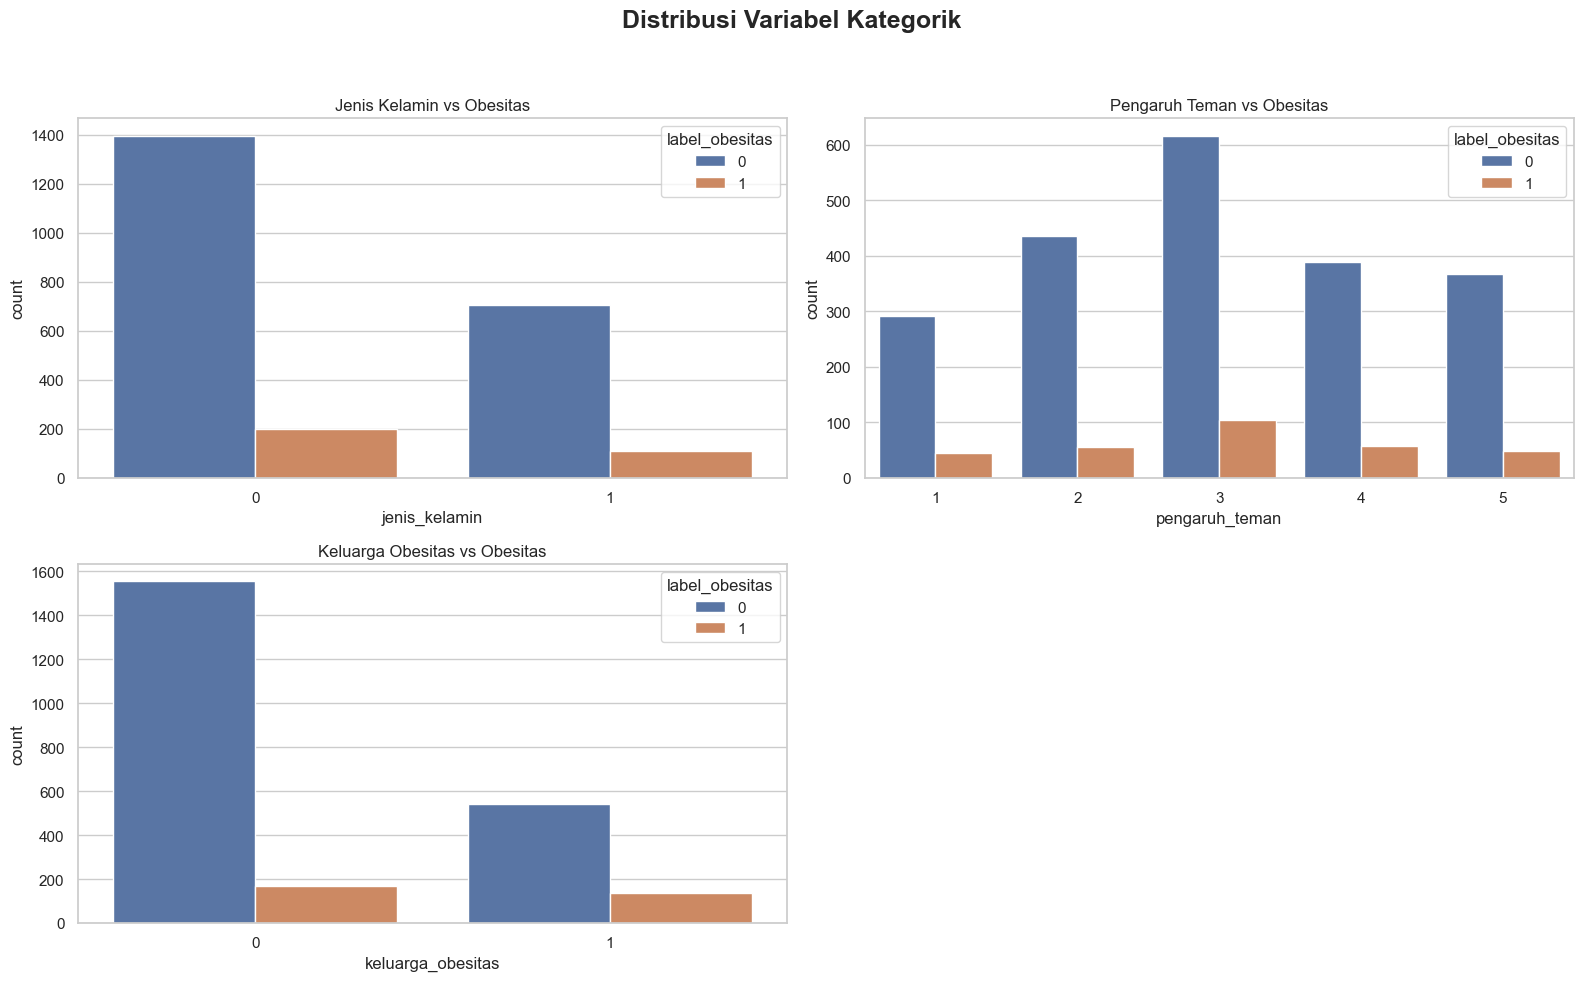

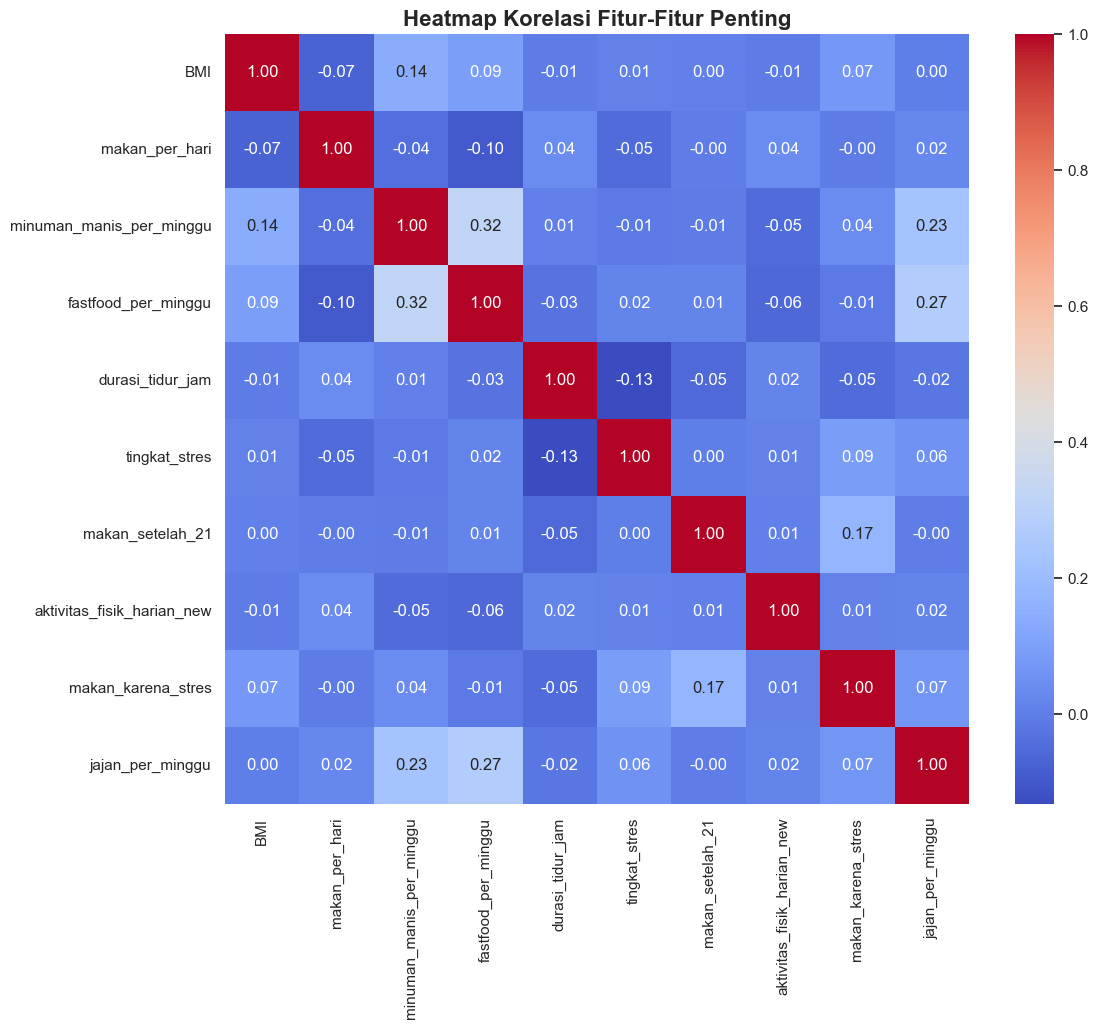

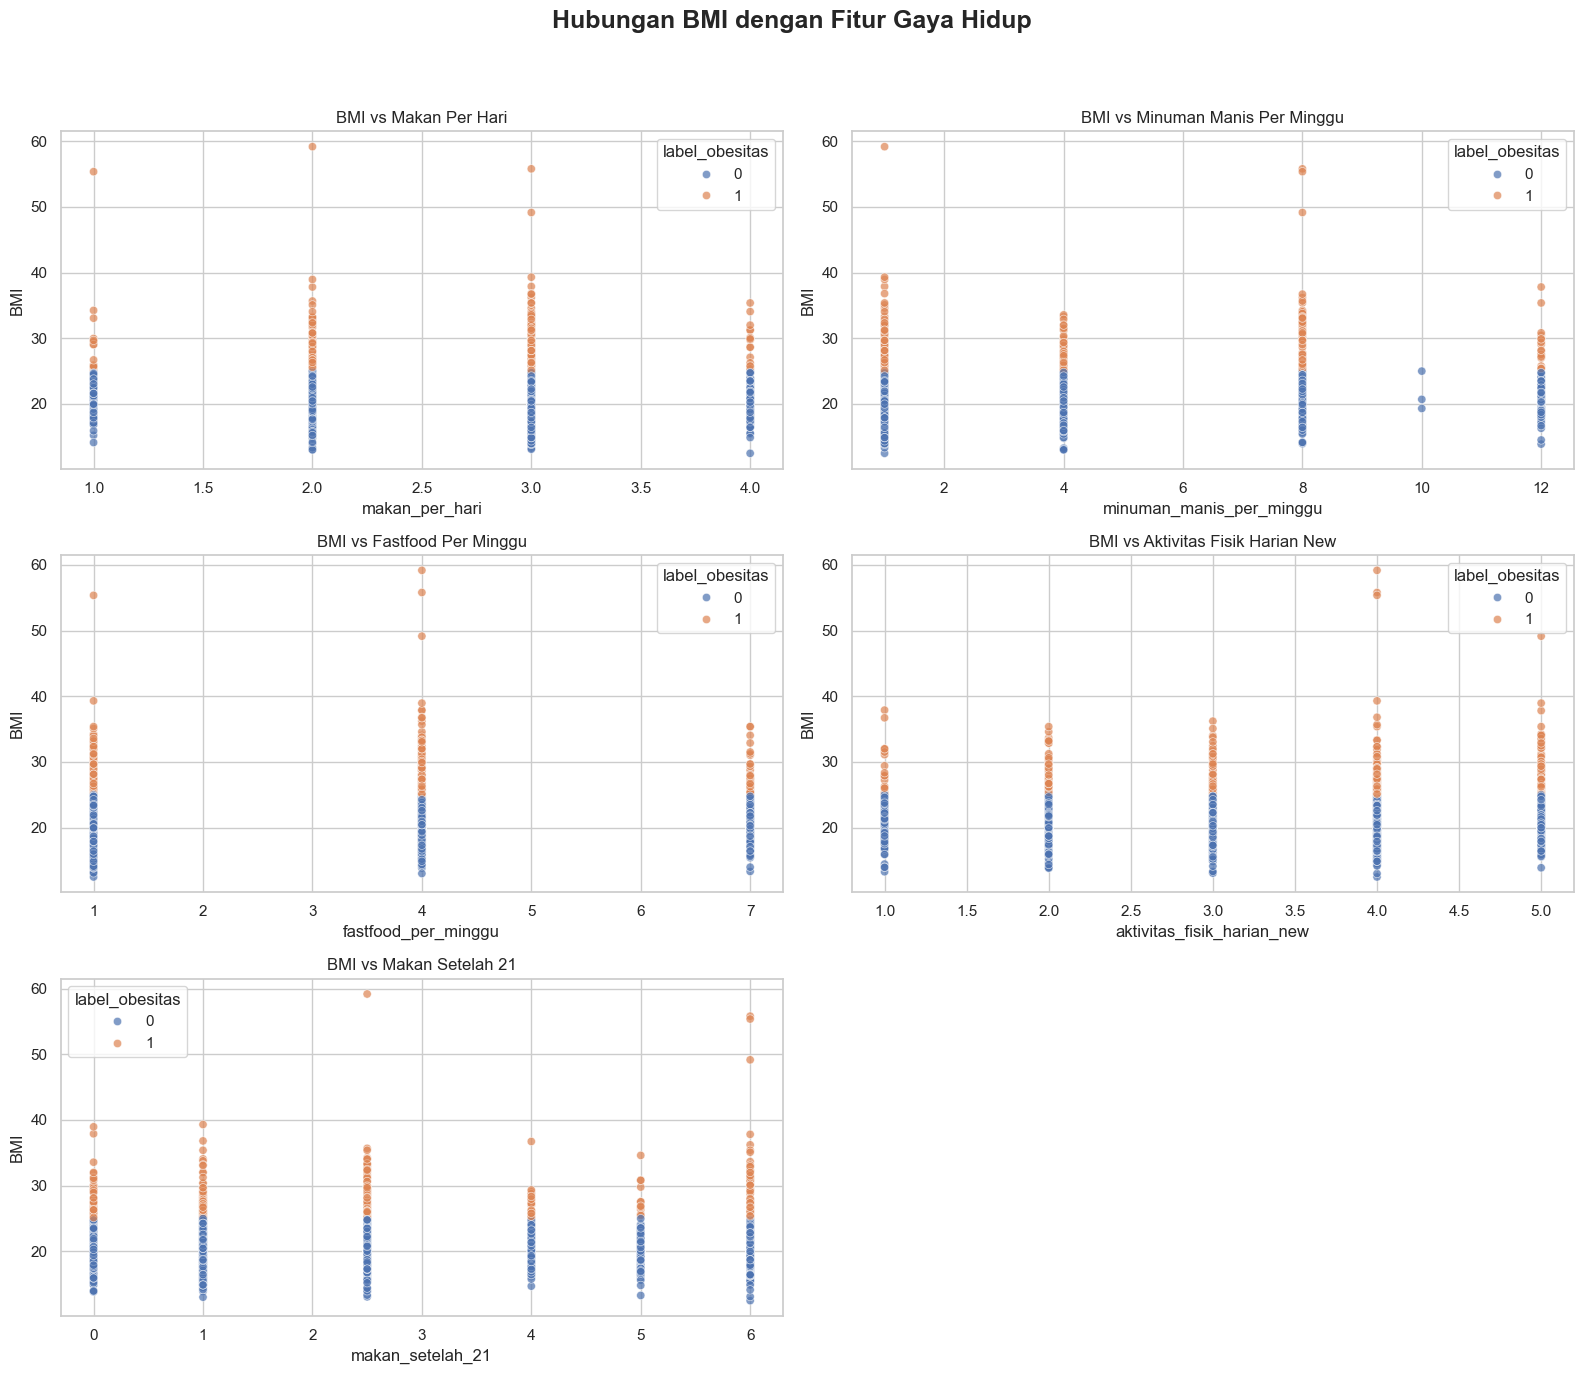

<Figure size 1600x1000 with 0 Axes>

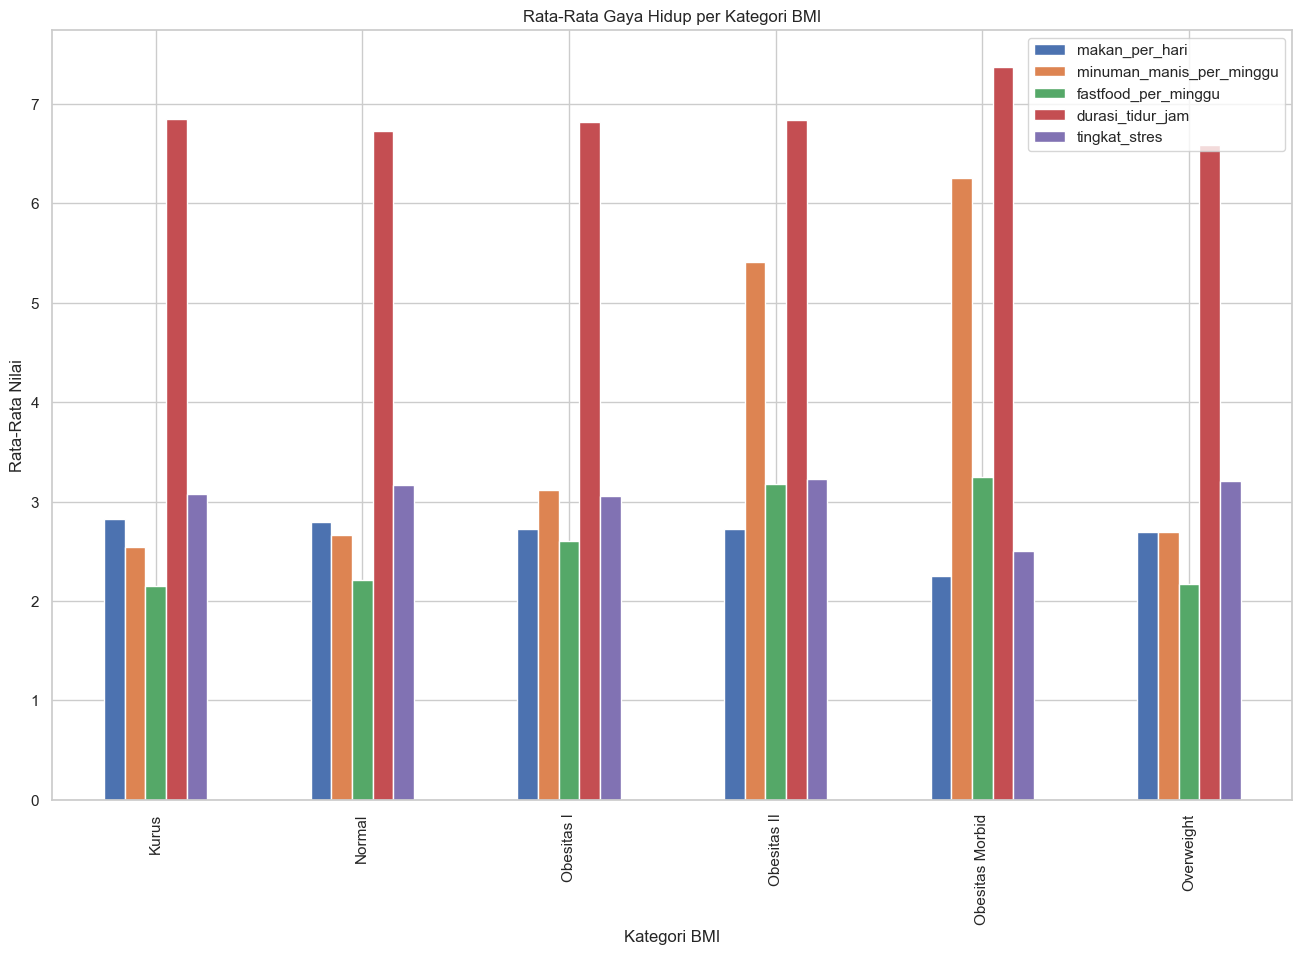

In [153]:
# EDA VISUALISASI

# 1. Distribusi Variabel Numerik (Histogram + KDE)
num_cols = [
    'usia_tahun', 'makan_per_hari', 'minuman_manis_per_minggu',
    'fastfood_per_minggu', 'jajan_per_minggu', 'durasi_tidur_jam',
    'tingkat_stres', 'makan_setelah_21', 'aktivitas_fisik_harian_new',
    'makan_karena_stres'
]

plt.figure(figsize=(18, 14))
plt.suptitle("Distribusi Variabel Numerik", fontsize=18, fontweight='bold')

for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col.replace("_"," ").title())

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


# 2. Boxplot fitur-fitur penting vs Obesitas
box_cols = [
    'makan_per_hari', 'minuman_manis_per_minggu', 'fastfood_per_minggu',
    'jajan_per_minggu', 'durasi_tidur_jam', 'tingkat_stres',
    'makan_setelah_21', 'aktivitas_fisik_harian_new'
]

plt.figure(figsize=(18, 14))
plt.suptitle("Perbandingan Fitur Penting terhadap Obesitas", fontsize=18, fontweight='bold')

for i, col in enumerate(box_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df["label_obesitas"], y=df[col])
    plt.title(f"{col.replace('_', ' ').title()} vs Obesitas")
    plt.xlabel("Obesitas (0=Tidak, 1=Ya)")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# 3. Countplot variabel kategorik
cat_cols = ['jenis_kelamin', 'pengaruh_teman', 'keluarga_obesitas']

plt.figure(figsize=(16, 10))
plt.suptitle("Distribusi Variabel Kategorik", fontsize=18, fontweight='bold')

for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df, x=col, hue="label_obesitas")
    plt.title(f"{col.replace('_',' ').title()} vs Obesitas")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# 4. Korelasi (HEATMAP) — Hanya Fitur Penting
corr_cols = [
    'BMI','makan_per_hari','minuman_manis_per_minggu',
    'fastfood_per_minggu','durasi_tidur_jam','tingkat_stres',
    'makan_setelah_21','aktivitas_fisik_harian_new','makan_karena_stres',
    'jajan_per_minggu'
]

plt.figure(figsize=(12,10))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Fitur-Fitur Penting", fontsize=16, fontweight='bold')
plt.show()


# 5. Scatterplot BMI vs fitur paling relevan
important_scatter = [
    'makan_per_hari', 'minuman_manis_per_minggu',
    'fastfood_per_minggu', 'aktivitas_fisik_harian_new',
    'makan_setelah_21'
]

plt.figure(figsize=(16, 14))
plt.suptitle("Hubungan BMI dengan Fitur Gaya Hidup", fontsize=18, fontweight='bold')

for i, col in enumerate(important_scatter):
    plt.subplot(3, 2, i+1)
    sns.scatterplot(data=df, x=col, y="BMI", hue="label_obesitas", alpha=0.7)
    plt.title(f"BMI vs {col.replace('_',' ').title()}")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# 6. Bar Chart Mean Fitur Berdasarkan Kategori BMI
plt.figure(figsize=(16, 10))
plt.suptitle("Rata-rata Fitur Gaya Hidup per Kategori BMI", fontsize=18, fontweight='bold')

mean_cols = ['makan_per_hari', 'minuman_manis_per_minggu',
             'fastfood_per_minggu', 'durasi_tidur_jam', 'tingkat_stres']

df_group = df.groupby("kategori_BMI")[mean_cols].mean()

df_group.plot(kind='bar', figsize=(16,10))
plt.title("Rata-Rata Gaya Hidup per Kategori BMI")
plt.xlabel("Kategori BMI")
plt.ylabel("Rata-Rata Nilai")
plt.legend(loc='upper right')
plt.show()


In [155]:
# ==========================================
# 5. DATA PREPARATION UNTUK ML
# ==========================================
print("\n" + "="*70)
print("TAHAP 5: DATA PREPARATION UNTUK ML")
print("="*70)

# 5.1 Pilih fitur
features = [
    "usia_tahun",
    "jenis_kelamin",
    "makan_per_hari",
    "minuman_manis_per_minggu",
    "fastfood_per_minggu",
    "jajan_per_minggu",
    "aktivitas_fisik",
    "durasi_tidur_jam",
    "tingkat_stres",
    "pengaruh_teman",
    "keluarga_obesitas",
    "makan_setelah_21",
    "aktivitas_fisik_harian_new",
    "makan_karena_stres",
    "video_makanan"
]

# Filter fitur yang ada di dataframe
available_features = [f for f in features if f in df.columns]
print(f"Fitur tersedia: {len(available_features)} dari {len(features)} features")
print(f"  Fitur yang digunakan: {available_features}")

missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"  Fitur tidak ditemukan: {missing_features}")

X = df[available_features]
y = df["label_obesitas"]

print(f"\nShape X: {X.shape}")
print(f"  Target distribution: {y.value_counts().to_dict()}")



TAHAP 5: DATA PREPARATION UNTUK ML
Fitur tersedia: 15 dari 15 features
  Fitur yang digunakan: ['usia_tahun', 'jenis_kelamin', 'makan_per_hari', 'minuman_manis_per_minggu', 'fastfood_per_minggu', 'jajan_per_minggu', 'aktivitas_fisik', 'durasi_tidur_jam', 'tingkat_stres', 'pengaruh_teman', 'keluarga_obesitas', 'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres', 'video_makanan']

Shape X: (2405, 15)
  Target distribution: {0: 2099, 1: 306}


In [156]:

# 5.2 Train-test split dengan stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split: train={X_train.shape[0]}, test={X_test.shape[0]}")

# 5.3 Imputasi SEBELUM scaling
imputer_ml = SimpleImputer(strategy='median')
X_train_imputed = imputer_ml.fit_transform(X_train)
X_test_imputed = imputer_ml.transform(X_test)
print("Missing values diimputasi dengan median")

# 5.4 Scaling dengan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print("Feature scaling dengan StandardScaler")

# 5.5 SMOTE untuk balance data
print("\nSMOTE - Synthetic Minority Over-sampling Technique:")
try:
    k_neighbors = min(5, y_train.sum()-1)
    if k_neighbors < 1:
        k_neighbors = 1
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
    print(f"SMOTE applied:")
    print(f"  - Sebelum: Obesity={y_train.sum()}, Non-Obesity={len(y_train)-y_train.sum()}")
    print(f"  - Sesudah: Obesity={y_train_sm.sum()}, Non-Obesity={len(y_train_sm)-y_train_sm.sum()}")
    smote_applied = True
except Exception as e:
    print(f"SMOTE gagal: {e}")
    print("  Menggunakan data asli tanpa oversampling")
    X_train_sm, y_train_sm = X_train_scaled, y_train
    smote_applied = False




Data split: train=1924, test=481
Missing values diimputasi dengan median
Feature scaling dengan StandardScaler

SMOTE - Synthetic Minority Over-sampling Technique:
SMOTE applied:
  - Sebelum: Obesity=245, Non-Obesity=1679
  - Sesudah: Obesity=1679, Non-Obesity=1679


In [157]:
# ==========================================
# 6. MODELING - LOGISTIC REGRESSION
# ==========================================
print("\n" + "="*70)
print("TAHAP 6: MODELING - LOGISTIC REGRESSION")
print("="*70)

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
logreg.fit(X_train_sm, y_train_sm)

y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression trained")
print(f"  Coefficients shape: {logreg.coef_.shape}")



TAHAP 6: MODELING - LOGISTIC REGRESSION
Logistic Regression trained
  Coefficients shape: (1, 15)


In [158]:
# ==========================================
# 7. MODELING - RANDOM FOREST
# ==========================================
print("\n" + "="*70)
print("TAHAP 7: MODELING - RANDOM FOREST")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5
)
rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("Random Forest trained")
print(f"  Number of trees: {rf.n_estimators}")



TAHAP 7: MODELING - RANDOM FOREST
Random Forest trained
  Number of trees: 100


In [159]:
# ==========================================
# 8. OPTIMAL THRESHOLD TUNING
# ==========================================
print("\n" + "="*70)
print("TAHAP 8: OPTIMAL THRESHOLD TUNING")
print("="*70)

def find_optimal_threshold(y_true, y_prob):
    """Cari threshold optimal menggunakan Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[best_idx]
    return optimal_threshold

threshold_lr = find_optimal_threshold(y_test, y_prob_logreg)
threshold_rf = find_optimal_threshold(y_test, y_prob_rf)

print(f"Optimal Threshold - Logistic Regression: {threshold_lr:.4f}")
print(f"Optimal Threshold - Random Forest: {threshold_rf:.4f}")

# Apply optimal threshold
y_pred_logreg_opt = (y_prob_logreg >= threshold_lr).astype(int)
y_pred_rf_opt = (y_prob_rf >= threshold_rf).astype(int)

print("\nOptimal threshold diterapkan")



TAHAP 8: OPTIMAL THRESHOLD TUNING
Optimal Threshold - Logistic Regression: 0.4883
Optimal Threshold - Random Forest: 0.3404

Optimal threshold diterapkan


In [160]:
# ==========================================
# 9. MODEL EVALUATION
# ==========================================
print("\n" + "="*70)
print("TAHAP 9: MODEL EVALUATION - DEFAULT vs OPTIMAL THRESHOLD")
print("="*70)

def evaluate_model(title, y_true, y_pred, y_prob):
    """Fungsi untuk evaluasi model"""
    print(f"\n{title}")
    print("-" * 60)
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    try:
        auc_val = roc_auc_score(y_true, y_prob)
        print(f"AUC-ROC:   {auc_val:.4f}")
    except:
        auc_val = 0
        print(f"AUC-ROC:   N/A (insufficient classes)")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Obesity', 'Obesity'], zero_division=0))
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, zero_division=0)

# Evaluasi dengan default threshold (0.5)
print("\nDEFAULT THRESHOLD (0.5):")
acc_lr_def, f1_lr_def = evaluate_model("LOGISTIC REGRESSION", y_test, y_pred_logreg, y_prob_logreg)
acc_rf_def, f1_rf_def = evaluate_model("RANDOM FOREST", y_test, y_pred_rf, y_prob_rf)

# Evaluasi dengan optimal threshold
print("\n\nOPTIMAL THRESHOLD:")
acc_lr_opt, f1_lr_opt = evaluate_model(f"LOGISTIC REGRESSION (Threshold={threshold_lr:.4f})", y_test, y_pred_logreg_opt, y_prob_logreg)
acc_rf_opt, f1_rf_opt = evaluate_model(f"RANDOM FOREST (Threshold={threshold_rf:.4f})", y_test, y_pred_rf_opt, y_prob_rf)



TAHAP 9: MODEL EVALUATION - DEFAULT vs OPTIMAL THRESHOLD

DEFAULT THRESHOLD (0.5):

LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy:  0.6403
Precision: 0.2113
Recall:    0.6721
F1-Score:  0.3216
AUC-ROC:   0.7011

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.93      0.64      0.76       420
     Obesity       0.21      0.67      0.32        61

    accuracy                           0.64       481
   macro avg       0.57      0.65      0.54       481
weighted avg       0.84      0.64      0.70       481


RANDOM FOREST
------------------------------------------------------------
Accuracy:  0.8794
Precision: 0.5882
Recall:    0.1639
F1-Score:  0.2564
AUC-ROC:   0.6648

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.89      0.98      0.93       420
     Obesity       0.59      0.16      0.26        61

    accuracy                           


TAHAP 10: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE


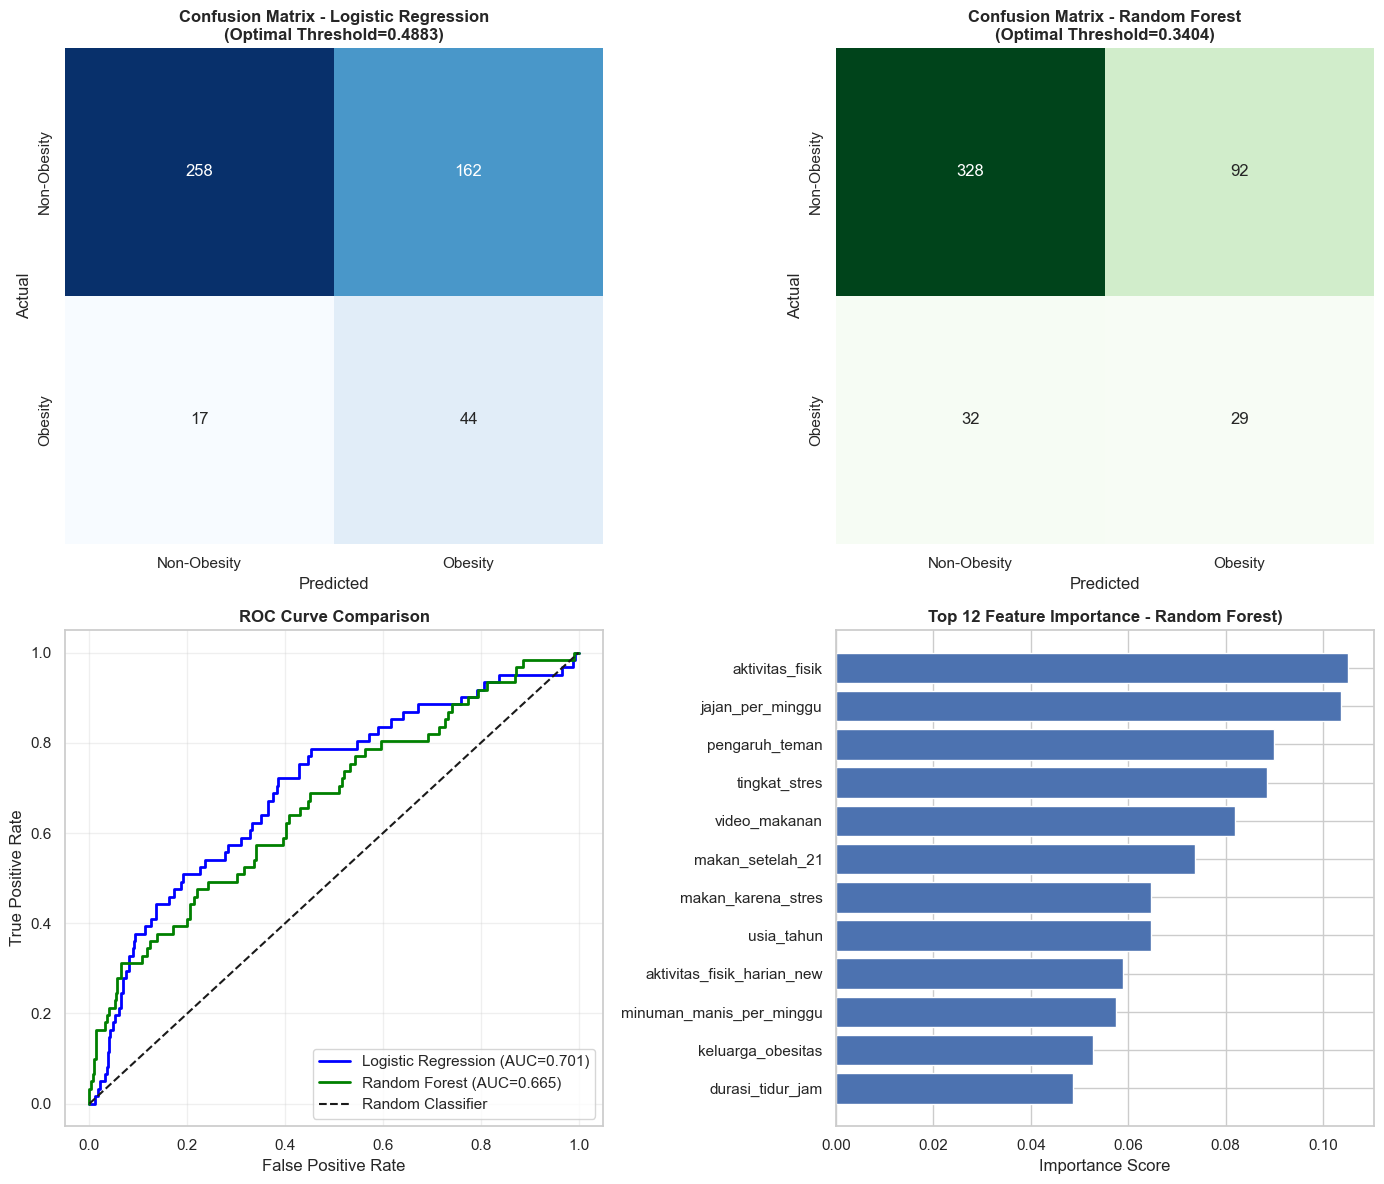

Evaluasi model disimpan: model_evaluation.png


In [161]:
# ==========================================
# 10. VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE
# ==========================================
print("\n" + "="*70)
print("TAHAP 10: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_logreg_opt)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False)
axes[0, 0].set_title(f"Confusion Matrix - Logistic Regression\n(Optimal Threshold={threshold_lr:.4f})", fontweight='bold')
axes[0, 0].set_ylabel("Actual")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_xticklabels(['Non-Obesity', 'Obesity'])
axes[0, 0].set_yticklabels(['Non-Obesity', 'Obesity'])

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_opt)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title(f"Confusion Matrix - Random Forest\n(Optimal Threshold={threshold_rf:.4f})", fontweight='bold')
axes[0, 1].set_ylabel("Actual")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_xticklabels(['Non-Obesity', 'Obesity'])
axes[0, 1].set_yticklabels(['Non-Obesity', 'Obesity'])

# ROC Curve
try:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    auc_lr = roc_auc_score(y_test, y_prob_logreg)
    auc_rf = roc_auc_score(y_test, y_prob_rf)

    axes[1, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2, color='blue')
    axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2, color='green')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 0].set_xlabel("False Positive Rate")
    axes[1, 0].set_ylabel("True Positive Rate")
    axes[1, 0].set_title("ROC Curve Comparison", fontweight='bold')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(alpha=0.3)
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f"ROC Curve unavailable\n{e}", ha='center', va='center')
    auc_lr, auc_rf = 0, 0

# Feature Importance - Random Forest
feat_importance = pd.Series(rf.feature_importances_, index=available_features).sort_values(ascending=False)

new_features = ['makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres']
colors = ['coral' if f in new_features else 'steelblue' for f in feat_importance.index[:12]]

axes[1, 1].barh(feat_importance.index[:12], feat_importance.values[:12])
axes[1, 1].set_xlabel("Importance Score")
axes[1, 1].set_title("Top 12 Feature Importance - Random Forest)", fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig("model_evaluation.png", dpi=300, bbox_inches='tight')
plt.show()
print("Evaluasi model disimpan: model_evaluation.png")



In [162]:
# ==========================================
# 11. SAVE MODEL
# ==========================================
print("\n" + "="*70)
print("TAHAP 11: MENYIMPAN MODEL & ARTIFACTS")
print("="*70)

model_data = {
    'logreg': logreg,
    'rf': rf,
    'scaler': scaler,
    'imputer': imputer_ml,
    'features': available_features,
    'threshold_lr': threshold_lr,
    'threshold_rf': threshold_rf,
    'feature_importance': feat_importance.to_dict(),
    'smote_applied': smote_applied
}

with open("model_data.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Semua model dan artifacts berhasil disimpan!")
print("  - model_data.pkl")




TAHAP 11: MENYIMPAN MODEL & ARTIFACTS
Semua model dan artifacts berhasil disimpan!
  - model_data.pkl


In [163]:
# ==========================================
# 12. KESIMPULAN & REKOMENDASI
# ==========================================
print("\n" + "="*70)
print("TAHAP 12: KESIMPULAN & REKOMENDASI")
print("="*70)

best_model = "Random Forest" if f1_rf_opt > f1_lr_opt else "Logistic Regression"
best_f1 = max(f1_rf_opt, f1_lr_opt)
best_auc = max(auc_lr, auc_rf) if 'auc_lr' in dir() and 'auc_rf' in dir() else 0

insights = f"""
SUMMARY ANALISIS OBESITAS SISWA (DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: {df.shape[0]}
   - Persentase obesitas (BMI >= 25): {df['label_obesitas'].mean()*100:.2f}%
   - Rata-rata BMI: {df['BMI'].mean():.2f}
   - Jumlah fitur: {len(available_features)}

2. KATEGORI BMI DISTRIBUTION (Standar Asia):
{df['kategori_BMI'].value_counts(normalize=True).mul(100).round(2)}

3. 3 FITUR BARU YANG DITAMBAHKAN:
   ✓ makan_setelah_21: Frekuensi makan setelah jam 21.00
   ✓ aktivitas_fisik_harian_new: Aktivitas fisik (jalan kaki, naik & turun tangga)
   ✓ makan_karena_stres: Frekuensi makan akibat stres

4. FAKTOR PALING BERPENGARUH (TOP 10):
{chr(10).join([f"   {i+1}. {feat}: {imp:.4f}" for i, (feat, imp) in enumerate(feat_importance.head(10).items())])}

5. BEST MODEL PERFORMANCE (Optimal Threshold):
   - Model: {best_model}
   - Accuracy: {max(acc_lr_opt, acc_rf_opt):.4f}
   - F1-Score: {best_f1:.4f}
   - AUC-ROC: {best_auc:.4f}
   - Threshold LR: {threshold_lr:.4f}
   - Threshold RF: {threshold_rf:.4f}

6. SMOTE Applied: {smote_applied}

7. REKOMENDASI KESEHATAN:
   a) Hindari makan setelah jam 21.00 (late-night eating)
   b) Tingkatkan aktivitas fisik harian (jalan kaki, naik turun tangga)
   c) Kelola stres dengan baik (hindari emotional eating)
   d) Kurangi konsumsi minuman manis (< 3 gelas/minggu)
   e) Tidur 7-8 jam setiap malam
   f) Batasi fast food (< 2 kali/minggu)
"""
print(insights)



TAHAP 12: KESIMPULAN & REKOMENDASI

SUMMARY ANALISIS OBESITAS SISWA (DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: 2405
   - Persentase obesitas (BMI >= 25): 12.72%
   - Rata-rata BMI: 21.40
   - Jumlah fitur: 15

2. KATEGORI BMI DISTRIBUTION (Standar Asia):
kategori_BMI
Normal             56.72
Kurus              18.46
Overweight         12.10
Obesitas I          9.81
Obesitas II         2.74
Obesitas Morbid     0.17
Name: proportion, dtype: float64

3. 3 FITUR BARU YANG DITAMBAHKAN:
   ✓ makan_setelah_21: Frekuensi makan setelah jam 21.00
   ✓ aktivitas_fisik_harian_new: Aktivitas fisik (jalan kaki, naik & turun tangga)
   ✓ makan_karena_stres: Frekuensi makan akibat stres

4. FAKTOR PALING BERPENGARUH (TOP 10):
   1. aktivitas_fisik: 0.1052
   2. jajan_per_minggu: 0.1037
   3. pengaruh_teman: 0.0900
   4. tingkat_stres: 0.0885
   5. video_makanan: 0.0819
   6. makan_setelah_21: 0.0737
   7. makan_karena_stres: 0.0646
   8. usia_tahun: 0.0646
   9. aktivitas_fisik_haria

In [166]:

# ==========================================
# 13. TEST PREDIKSI REALTIME
# ==========================================
print("\n" + "="*70)
print("TEST PREDIKSI REALTIME - CONSISTENT MODELS")
print("="*70)

def predict_obesity(usia, jenis_kelamin, makan, minuman_manis, fastfood, jajan,
                   aktivitas, tidur, stres, teman, keluarga_obesitas,
                   makan_setelah_21=2, aktivitas_fisik_baru=3, makan_karena_stres=2,video_makanan=2):
    

    jk_encode = 1 if jenis_kelamin.lower() == "laki-laki" else 0
    keluarga_encode = 1 if keluarga_obesitas.lower() == "iya" else 0

    data_dict = {
        'usia_tahun': usia,
        'jenis_kelamin': jk_encode,
        'makan_per_hari': makan,
        'minuman_manis_per_minggu': minuman_manis,
        'fastfood_per_minggu': fastfood,
        'jajan_per_minggu': jajan,
        'aktivitas_fisik': aktivitas,
        'durasi_tidur_jam': tidur,
        'tingkat_stres': stres,
        'pengaruh_teman': teman,
        'keluarga_obesitas': keluarga_encode,
        'makan_setelah_21': makan_setelah_21,
        'aktivitas_fisik_harian_new': aktivitas_fisik_baru,
        'makan_karena_stres': makan_karena_stres,
        'video_makanan': video_makanan
    }

    # Hanya gunakan fitur yang tersedia
    data_values = [data_dict[f] for f in available_features]
    data = pd.DataFrame([data_values], columns=available_features)

    data_imputed = imputer_ml.transform(data)
    data_scaled = scaler.transform(data_imputed)

    # Prediksi dengan kedua model
    prob_lr = logreg.predict_proba(data_scaled)[0, 1]
    prob_rf = rf.predict_proba(data_scaled)[0, 1]

    pred_lr = 1 if prob_lr >= threshold_lr else 0
    pred_rf = 1 if prob_rf >= threshold_rf else 0

    prob_ensemble = (prob_lr + prob_rf) / 2
    pred_ensemble = 1 if prob_ensemble >= 0.5 else 0

    return {
        'logistic_regression': {'probability': prob_lr, 'prediction': pred_lr},
        'random_forest': {'probability': prob_rf, 'prediction': pred_rf},
        'ensemble': {'probability': prob_ensemble, 'prediction': pred_ensemble}
    }

print("\n" + "-"*70)
print("[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:")
result1 = predict_obesity(
    usia=17, jenis_kelamin="Laki-laki", makan=3, minuman_manis=12,
    fastfood=7, jajan=10, aktivitas=1, tidur=4, stres=5, teman=5,
    keluarga_obesitas="Iya", makan_setelah_21=6, aktivitas_fisik_baru=1, makan_karena_stres=5, video_makanan=10
)
print(f"  Logistic Regression: {'OBESITAS' if result1['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result1['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result1['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result1['ensemble']['probability']*100:.2f}%)")

print("\n" + "-"*70)
print("[TEST 2] Siswa dengan Gaya Hidup Sehat:")
result2 = predict_obesity(
    usia=16, jenis_kelamin="Perempuan", makan=3, minuman_manis=1,
    fastfood=1, jajan=1, aktivitas=5, tidur=7.5, stres=1, teman=1,
    keluarga_obesitas="Tidak", makan_setelah_21=0, aktivitas_fisik_baru=5, makan_karena_stres=1, video_makanan=1
)
print(f"  Logistic Regression: {'OBESITAS' if result2['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result2['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result2['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result2['ensemble']['probability']*100:.2f}%)")

print("\n" + "-"*70)
print("[TEST 3] Siswa dengan Gaya Hidup Sedang:")
result3 = predict_obesity(
    usia=16, jenis_kelamin="Laki-laki", makan=3, minuman_manis=4,
    fastfood=4, jajan=4, aktivitas=3, tidur=5.5, stres=3, teman=3,
    keluarga_obesitas="Tidak", makan_setelah_21=2.5, aktivitas_fisik_baru=3, makan_karena_stres=3, video_makanan=2
)
print(f"  Logistic Regression: {'OBESITAS' if result3['logistic_regression']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['logistic_regression']['probability']*100:.2f}%)")
print(f"  Random Forest: {'OBESITAS' if result3['random_forest']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['random_forest']['probability']*100:.2f}%)")
print(f"  Ensemble: {'OBESITAS' if result3['ensemble']['prediction']==1 else 'TIDAK OBESITAS'} ({result3['ensemble']['probability']*100:.2f}%)")



TEST PREDIKSI REALTIME - CONSISTENT MODELS

----------------------------------------------------------------------
[TEST 1] Siswa dengan Gaya Hidup Tidak Sehat:
  Logistic Regression: OBESITAS (73.89%)
  Random Forest: TIDAK OBESITAS (29.06%)
  Ensemble: OBESITAS (51.47%)

----------------------------------------------------------------------
[TEST 2] Siswa dengan Gaya Hidup Sehat:
  Logistic Regression: TIDAK OBESITAS (43.24%)
  Random Forest: TIDAK OBESITAS (21.32%)
  Ensemble: TIDAK OBESITAS (32.28%)

----------------------------------------------------------------------
[TEST 3] Siswa dengan Gaya Hidup Sedang:
  Logistic Regression: TIDAK OBESITAS (48.19%)
  Random Forest: OBESITAS (44.92%)
  Ensemble: TIDAK OBESITAS (46.55%)
